In [1]:
import yfinance as yf

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_ta as ta
from multiprocessing.pool import Pool
from sklearn.manifold import TSNE
import pandas as pd
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from collections import Counter
from sklearn.neural_network import MLPClassifier

In [3]:
tickers = pd.read_html(
    'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
print(tickers.head())

  Symbol     Security             GICS Sector               GICS Sub-Industry  \
0    MMM           3M             Industrials        Industrial Conglomerates   
1    AOS  A. O. Smith             Industrials               Building Products   
2    ABT       Abbott             Health Care           Health Care Equipment   
3   ABBV       AbbVie             Health Care                   Biotechnology   
4    ACN    Accenture  Information Technology  IT Consulting & Other Services   

     Headquarters Location  Date added      CIK      Founded  
0    Saint Paul, Minnesota  1957-03-04    66740         1902  
1     Milwaukee, Wisconsin  2017-07-26    91142         1916  
2  North Chicago, Illinois  1957-03-04     1800         1888  
3  North Chicago, Illinois  2012-12-31  1551152  2013 (1888)  
4          Dublin, Ireland  2011-07-06  1467373         1989  


In [4]:
%%time
with open("hist_data_2018-1-1_2023-7-12.pkl","rb") as f:
    data = pickle.load(f)

CPU times: total: 15.6 ms
Wall time: 12.4 ms


In [5]:
columns = list(data["Open"].columns)

In [6]:
len(columns)

503

In [7]:
coli_with_na = np.where(np.sum(pd.isna(data["Close"]))>0)[0]
for coli in coli_with_na:
    print(columns[coli])

ABNB
BF.B
BRK.B
CARR
CDAY
CEG
CTVA
DOW
FOX
FOXA
GEHC
KVUE
MRNA
OTIS
UBER
VLTO


In [8]:
opens= data["Open"].drop(columns=[columns[coli] for coli in coli_with_na])
closes = data["Close"].drop(columns=[columns[coli] for coli in coli_with_na])
# Open	High	Low	Close	Volume
highs = data["High"].drop(columns=[columns[coli] for coli in coli_with_na])
lows = data["Low"].drop(columns=[columns[coli] for coli in coli_with_na])
volumes = data["Volume"].drop(columns=[columns[coli] for coli in coli_with_na])

In [9]:
opens.shape,closes.shape,highs.shape,lows.shape,volumes.shape

((1389, 487), (1389, 487), (1389, 487), (1389, 487), (1389, 487))

In [10]:
ticker="TSLA"
training_X=[]
training_Y=[]
correlation_Y = []
temp_df_full = pd.DataFrame(data={"Open":opens[ticker],
                         "High":highs[ticker],
                         "Low":lows[ticker],
                         "Close":closes[ticker],
                         "Volume":volumes[ticker],
                        })

In [11]:
def clamp(df,w_min,w_max):
    return (df-w_min)/(w_max-w_min)

In [12]:
t=0
window_size=25
temp_df = temp_df_full.iloc[t:window_size+t]
w_max = temp_df.max().High
w_min = temp_df.min().Low
assert w_min != w_max
ta_df_temp = pd.concat([
    clamp( temp_df.ta.sma() ,w_min,w_max),
    clamp( temp_df.ta.sma(length=20) ,w_min,w_max),
    clamp( temp_df.ta.ema() ,w_min,w_max),
    clamp( temp_df.ta.ema(length=20) ,w_min,w_max),
    clamp( temp_df.ta.rsi(), 0 , 100)
    ],axis=1)

<Axes: xlabel='Date'>

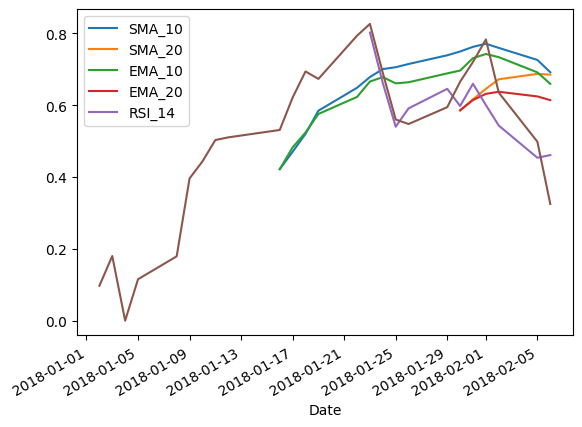

In [13]:
ta_df_temp.plot()
clamp(temp_df.Low,w_min,w_max).plot()

In [14]:
def funcc(x):
    ticker=x
    training_X=[]
    training_Y=[]
    correlation_Y = []
    temp_df_full = pd.DataFrame(data={"Open":opens[ticker],
                             "High":highs[ticker],
                             "Low":lows[ticker],
                             "Close":closes[ticker],
                             "Volume":volumes[ticker],
                            })
    t=0
    window_size = 34
    def clamp(df,w_min,w_max):
        return (df-w_min)/(w_max-w_min)
    while True:
        try:
            temp_df_full.iloc[window_size+t+1]
        except IndexError :
            break
        temp_df = temp_df_full.iloc[t:window_size+t]
        
        w_max = temp_df.max().High
        w_min = temp_df.min().Low
        assert w_min != w_max
        ta_df_temp = pd.concat([
                clamp( temp_df.ta.sma() ,w_min,w_max),
                clamp( temp_df.ta.sma(length=20) ,w_min,w_max),
                clamp( temp_df.ta.ema() ,w_min,w_max),
                clamp( temp_df.ta.ema(length=20) ,w_min,w_max),
                clamp( temp_df.ta.rsi(), 0 , 100)
              ],axis=1)
        ans = ta_df_temp.iloc[window_size-1-1].values
        ans_prev = ta_df_temp.iloc[window_size-1-1-1].values
        diff = ((ans[0]-ans[1])/4+0.5,(ans[2]-ans[3])/4+0.5)
        diff2 = ((ans_prev[0]-ans_prev[1])/4+0.5,(ans_prev[2]-ans_prev[3])/4+0.5)
        ans = np.hstack([ans,(ans-ans_prev)/4+0.5,diff,diff2])
        final_df = temp_df_full.iloc[window_size+t+1]
        result = (final_df["Close"]-final_df["Open"])/(final_df["Close"])
        training_X.append(ans)
        training_Y.append(result)
        correlation_Y.append( temp_df["Open"].iloc[-1] )
        t+=500
    return [training_X,training_Y,correlation_Y]

In [15]:
funcc("TSLA")

[[array([0.49140561, 0.63158663, 0.546891  , 0.56944321, 0.51303649,
         0.50062367, 0.4968075 , 0.50342883, 0.5010307 , 0.49884677,
         0.46495475, 0.49436195, 0.46113858, 0.49196382]),
  array([0.66941312, 0.48823799, 0.62394124, 0.50956624, 0.69708447,
         0.50659099, 0.50631802, 0.50433456, 0.50506308, 0.49817268,
         0.54529378, 0.52859375, 0.54502081, 0.52932227]),
  array([0.26687906, 0.39142892, 0.30659148, 0.37875913, 0.45544791,
         0.50021635, 0.49590976, 0.50032734, 0.49825591, 0.50514071,
         0.46886253, 0.48195809, 0.46455594, 0.47988666])],
 [0.03073626569256726, -0.006627299714664859, -0.004223136248243692],
 [22.29800033569336, 52.4813346862793, 301.84332275390625]]

In [16]:
a1 = np.arange(5)
a2 = np.arange(5)+2
np.hstack([a2,((a2-a1)/4+0.5)])

array([2., 3., 4., 5., 6., 1., 1., 1., 1., 1.])

In [17]:
from funcs_3_0_2 import funcc

In [18]:
%%time
dataa = [ ticker for ticker in opens.columns[:]]
with Pool(8) as pool:
    res = pool.map(funcc,dataa)

CPU times: total: 391 ms
Wall time: 2min 45s


In [19]:
training_X = np.vstack([r[0] for r in res])
training_Y = np.asarray([rr for r in res for rr in r[1]])
training_Y.shape
correlation_Y = np.asarray([rr for r in res for rr in r[2]])
correlation_Y.shape

(66232,)

In [20]:
newarr = []
for col in np.asarray(training_X).T:
    if np.sum(np.abs(col),axis=0)!=0:
        newarr.append(col)
training_X = np.asarray(newarr).T

training_X = np.asarray( training_X )
training_Y = np.asarray( training_Y )
correlation_Y = np.asarray( correlation_Y )

In [21]:
%%time
with open("hist_data_2018-1-1_2023-7-12_3_0_2.pkl","wb") as f:
    pickle.dump([training_X,training_Y,correlation_Y],f)

CPU times: total: 0 ns
Wall time: 15.7 ms


In [22]:
%%time
with open("hist_data_2018-1-1_2023-7-12_3_0_2.pkl","rb") as f:
    [training_X,training_Y,correlation_Y] = pickle.load(f)

CPU times: total: 0 ns
Wall time: 8.06 ms


In [23]:
training_X.shape,training_Y.shape,correlation_Y.shape

((66232, 14), (66232,), (66232,))

CPU times: total: 250 ms
Wall time: 334 ms


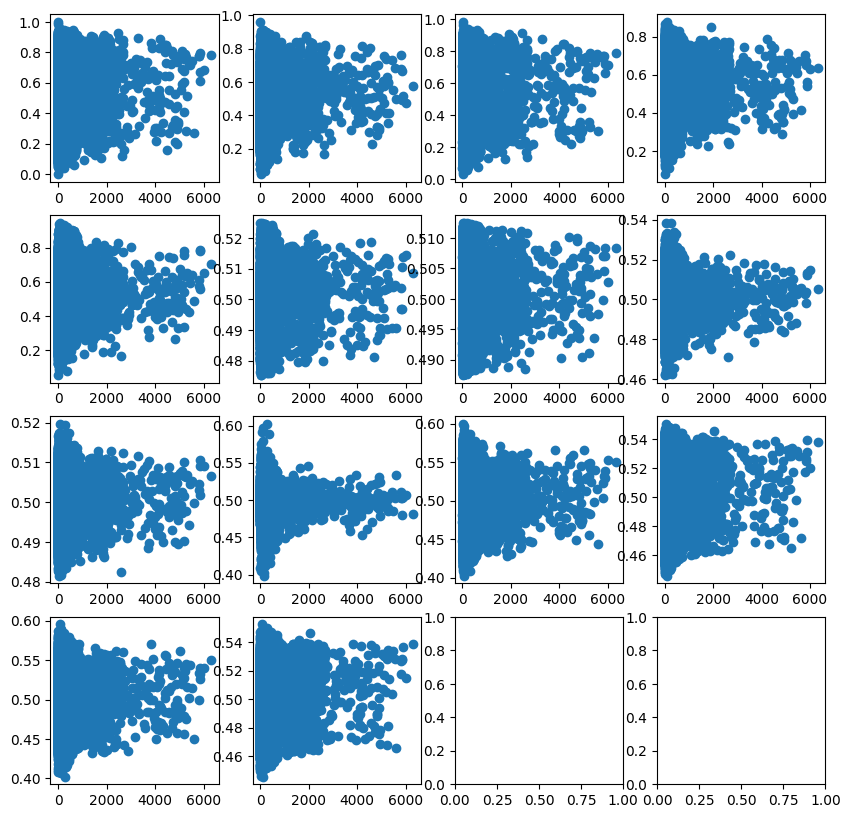

In [24]:
%%time
fig,axx=plt.subplots(4,4,figsize=(10,10))
axx=axx.ravel()
for scatter_i, ax in zip( range(len(training_X[0])),axx):
    ax.scatter(  y=training_X[:,scatter_i],x=correlation_Y)

In [25]:
X=np.asarray(training_X)

In [26]:
X[::6].shape

(4465, 14)

5
10
20
50
100
150
CPU times: total: 10min 40s
Wall time: 4min 5s


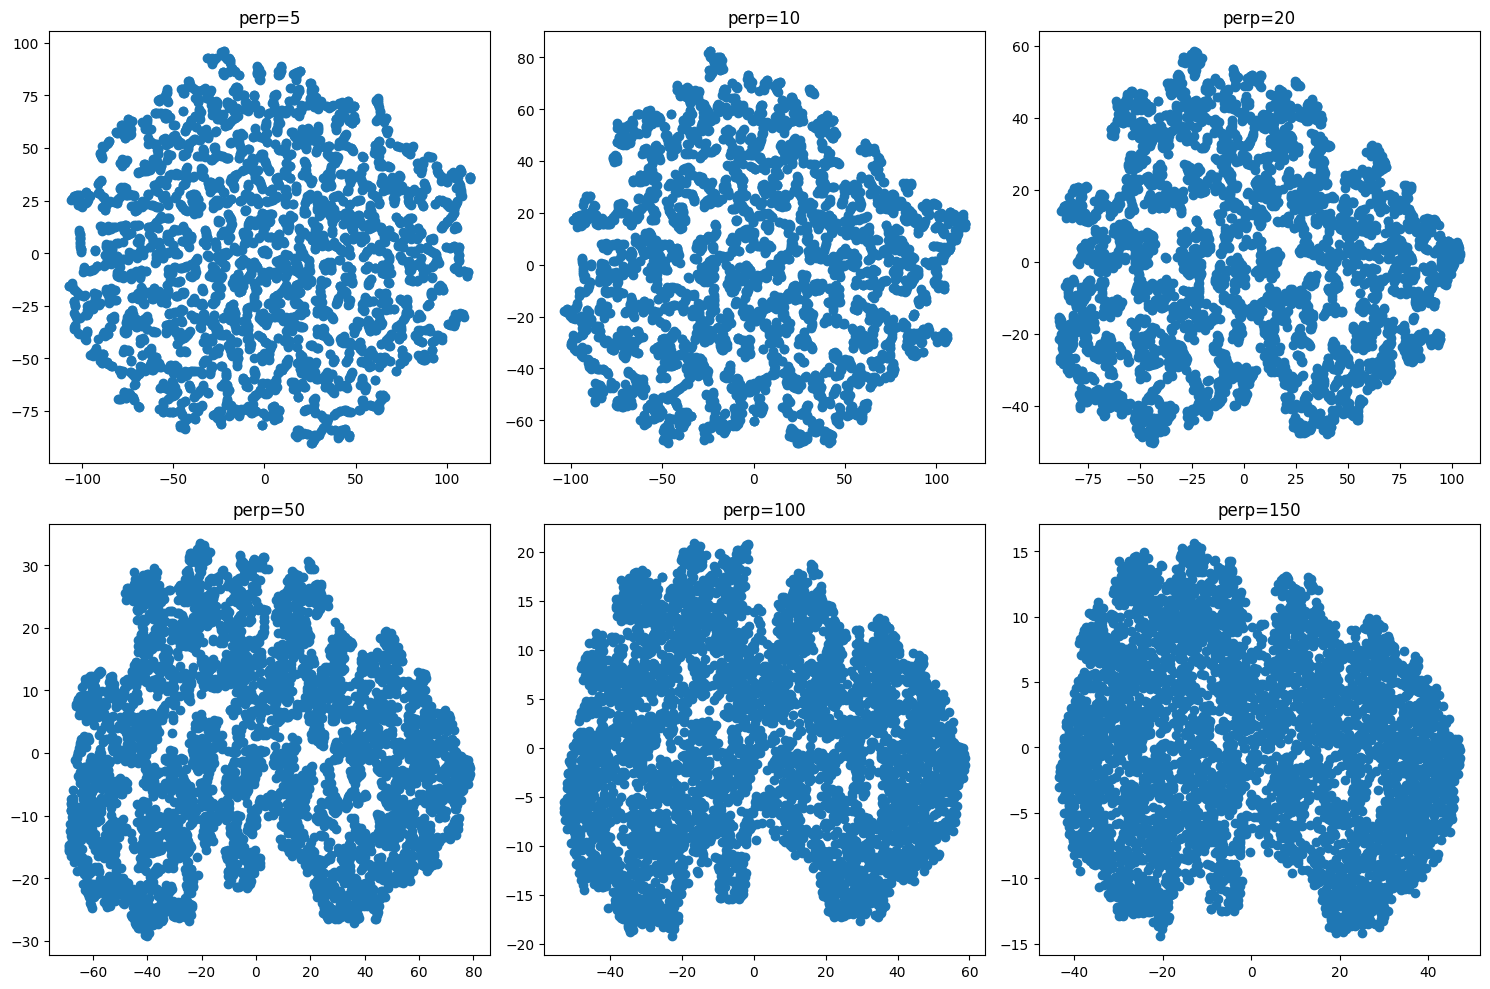

In [27]:
%%time
X=np.asarray(training_X)[::6]

fig,axx=plt.subplots(2,3,figsize=(15,10))
axx=axx.ravel()
for ax,perp in zip(axx,[5,10,20,50,100,150]):
    print(perp)
    X_embedded = TSNE(n_components=2,init='pca', perplexity=perp).fit_transform(X)
    ax.scatter(X_embedded[:,0],X_embedded[:,1])
    ax.set_title(f"perp={perp}")
plt.tight_layout()

CPU times: total: 46.9 ms
Wall time: 84 ms


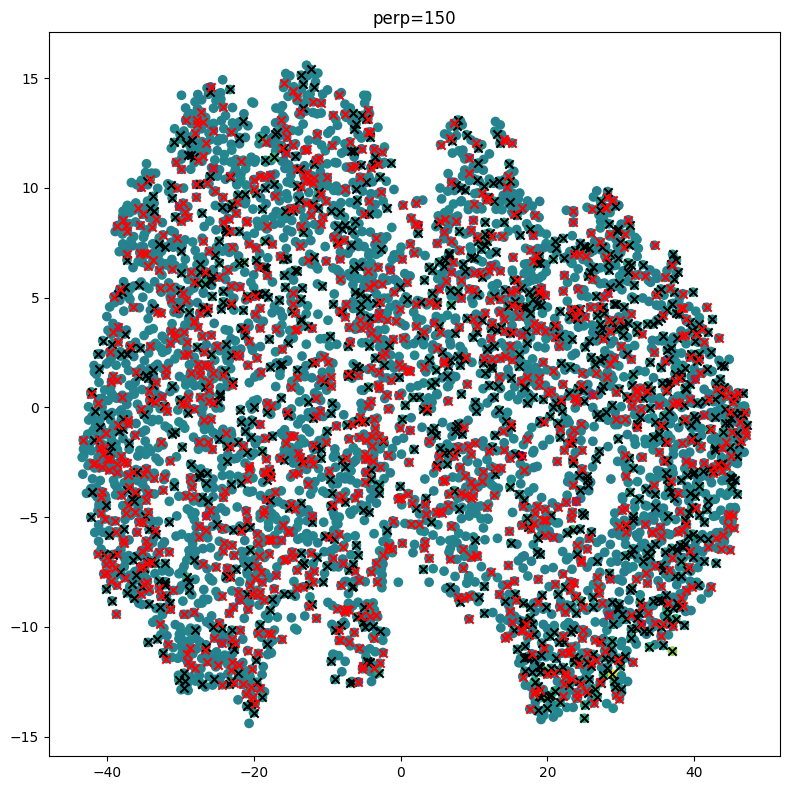

In [32]:
%%time
Y = np.asarray(training_Y)[::6]
threshold = 0.01
fig,axx=plt.subplots(1,1,figsize=(8,8)) 
ax=axx
#X_embedded = TSNE(n_components=2,init='pca', perplexity=perp).fit_transform(X)
ax.scatter(X_embedded[:,0],X_embedded[:,1],c=Y)
selected = Y>threshold

ax.scatter(X_embedded[selected,0],X_embedded[selected,1],c="k",marker="x")


selected = Y<-threshold

ax.scatter(X_embedded[selected,0],X_embedded[selected,1],c="r",marker="x")

ax.set_title(f"perp={perp}")
plt.tight_layout()

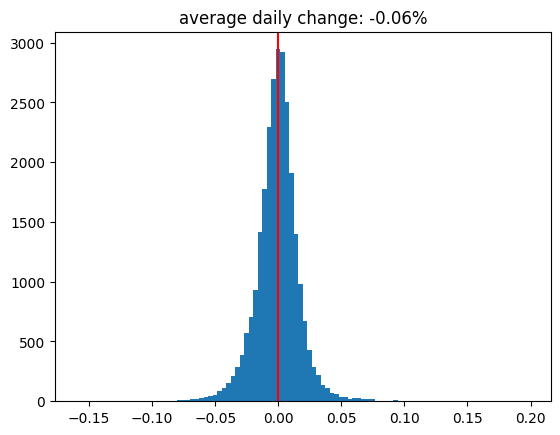

In [29]:
plt.hist(np.asarray(training_Y),bins=100);
plt.title(f"average daily change: {np.mean(training_Y):.2%}")
plt.axvline(0,c="r")

In [40]:
threshold = 0.02
train_data_y_discrete = np.asarray(list(map(lambda x: 2 if (x>threshold) else (1 if x<-threshold else 0),training_Y)))
Counter(train_data_y_discrete)

Counter({0: 52931, 1: 7168, 2: 6133})

In [41]:
X_train, X_test, y_train, y_test = train_test_split(training_X, train_data_y_discrete, test_size=0.3,random_state=109)

In [42]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((46362, 14), (19870, 14), (46362,), (19870,))

In [43]:
%%time
clf = svm.SVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

CPU times: total: 2min 5s
Wall time: 2min 19s


In [44]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred,average=None)) 
print("Recall:",metrics.recall_score(y_test, y_pred,average=None))

Accuracy: 0.7998490186210367
Precision: [0.79984902 0.         0.        ]
Recall: [1. 0. 0.]


C:\Users\alex\miniconda3\envs\cryt310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
%%time
# works clf = MLPClassifier(random_state=15, max_iter=500,hidden_layer_sizes=[150,150,50,10,50,150],).fit(X_train, y_train)
clf = MLPClassifier(random_state=15, max_iter=500,hidden_layer_sizes=[250,200,150,110,150,200,250],).fit(X_train, y_train)
y_pred = clf.predict(X_test)

CPU times: total: 17min 34s
Wall time: 30min 24s


In [46]:
Counter(y_pred)

Counter({0: 19753, 1: 94, 2: 23})

In [47]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred,average=None)) 
print("Recall:",metrics.recall_score(y_test, y_pred,average=None))

Accuracy: 0.800553598389532
Precision: [0.80246039 0.41489362 0.73913043]
Recall: [0.99735733 0.01809745 0.00933041]


In [48]:
y_pred_train = clf.predict(X_train)
print("Accuracy:",metrics.accuracy_score(y_train, y_pred_train))
print("Precision:",metrics.precision_score(y_train, y_pred_train,average=None)) 
print("Recall:",metrics.recall_score(y_train, y_pred_train,average=None))

Accuracy: 0.8007204175833657
Precision: [0.80186551 0.51470588 0.89655172]
Recall: [0.99805605 0.02094554 0.01206217]


In [49]:
Counter(y_pred_train)

Counter({0: 46100, 1: 204, 2: 58})

# this changes the "Training data"

In [33]:
# for binary clf
train_data_y_binary = np.asarray(list(map(lambda x: 1 if (x>0.04) else 0,training_Y)))
Counter(train_data_y_binary)

Counter({0: 65259, 1: 973})

In [34]:
X_train, X_test, y_train, y_test = train_test_split(training_X, train_data_y_binary, test_size=0.3,random_state=109)

In [70]:
from pyod.models.knn import KNN
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize

In [71]:
%%time
clf_name="KNN"
clf = KNN()
clf.fit(X_train)

CPU times: total: 375 ms
Wall time: 375 ms


KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [72]:
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

In [73]:
Counter(y_train_pred)

Counter({0: 16874, 1: 1875})

In [74]:
%%time
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

CPU times: total: 1.92 s
Wall time: 1.96 s


In [75]:
Counter(y_test_pred)

Counter({0: 7213, 1: 823})

In [76]:
y_train

array([0, 0, 0, ..., 0, 0, 0])

In [77]:
# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)


On Training Data:
KNN ROC:0.5595, precision @ rank n:0.0271

On Test Data:
KNN ROC:0.5463, precision @ rank n:0.0172


In [78]:
GT = y_test
pred = y_test_pred
print("Accuracy:",metrics.accuracy_score(GT, pred))
print("Precision:",metrics.precision_score(GT, pred,average=None)) 
print("Recall:",metrics.recall_score(GT, pred,average=None))
GT = y_train
pred = y_train_pred
print("Accuracy:",metrics.accuracy_score(GT, pred))
print("Precision:",metrics.precision_score(GT, pred,average=None)) 
print("Recall:",metrics.recall_score(GT, pred,average=None))

Accuracy: 0.8871329019412643
Precision: [0.98613614 0.01944107]
Recall: [0.89810606 0.13793103]
Accuracy: 0.8881006987039308
Precision: [0.98465094 0.0192    ]
Recall: [0.90034681 0.1220339 ]
